In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict
from functools import reduce

sns.set_theme()

api = wandb.Api()
projects = ["git-coco", "git-hp-search"]
def get_run_id(name):
    for project in projects:
        cands = api.runs(project, filters={"displayName": name})
        if len(cands) == 1:
            return "/".join(cands[0].path)

    raise Exception(f'Name "{name}" is not valid')


def output(fig, name, transparent=False, **kwargs):
    fig.savefig(f"charts/{name}.pdf", format="pdf", transparent=transparent, **kwargs)
    
def prepare_series(df, column_name, batch_size, epoch_size):
    run = df[['Step', column_name]]
    armadillo_filter = run[column_name].notnull()
    run = run.rename(columns={column_name: "value"})
    run = run[armadillo_filter]
    run['num_samples'] = run['Step'] * batch_size
    run['epoch'] = run['num_samples'] / epoch_size
    return run
    
def load_histories(runs, keys, x_axis):
    def crawl_one_run(iter):
        vals = defaultdict(dict)
        for i, id, col in iter:
            for point in i:
                vals[point[x_axis]][col] = point[col]

        return [{**v, x_axis: k, "run_id": id} for k, v in vals.items()]

    with ThreadPoolExecutor(max_workers=20) as ex:
        iters_gen = ex.map(
            lambda run: [
                (run.scan_history(keys=[col, x_axis]), run.id, col) for col in keys
            ],
            runs,
        )
        iters = list(tqdm(iters_gen, total=len(runs)))

        point_gen = ex.map(crawl_one_run, iters)
        points = reduce(list.__add__, tqdm(point_gen, total=len(iters)), list())

    return pd.DataFrame(points)

def load_summaries(runs, keys):
    with ThreadPoolExecutor(max_workers=5) as ex:
        data_gen = ex.map(lambda run: {"run_id": run.id, **{k: v for k, v in run.summary.items() if k in keys}}, runs)
        data = list(tqdm(data_gen, total=len(runs)))
    return pd.DataFrame(data)

def get_deep(d: dict[str], path: str, default = None):
    keys = path.split('.')
    pointer = d
    for key in keys:
        if pointer is None:
            return default
        pointer = pointer.get(key, None)
    return pointer

def load_configs(runs, deep_keys):
    with ThreadPoolExecutor(max_workers=5) as ex:
        data_gen = ex.map(lambda run: {"run_id": run.id, **{key: get_deep(run.config, key) for key in deep_keys}}, runs)
        data = list(tqdm(data_gen, total=len(runs)))
    return pd.DataFrame(data)

In [2]:
pre_train = api.run(get_run_id("northern-hill-44"))
fine_tune = api.run(get_run_id(("lemon-disco-46")))

In [3]:
def get_history(run):
    df = run.history()
    resulting_batch_size = (
        run.config["dataset"]["batch_size"]
        * run.config["train"]["batches_per_step"]
        * 2
    )
    df["num_samples"] = df["_step"] * resulting_batch_size
    return df

In [4]:
pre_train_hist = get_history(pre_train)
fine_tune_hist = get_history(fine_tune)
fine_tune_hist["num_samples"] += pre_train_hist["num_samples"].max()

pre_train_hist.head()

,_step,learning_rate,loss,accuracy,examples,_timestamp,epoch_time,_runtime,train_entropy,train_accuracy,entropy,num_samples
0,203,NaN,NaN,NaN,None,1.738587e+09,361.096161,360.635907,NaN,NaN,NaN,415744
1,405,NaN,NaN,NaN,None,1.738587e+09,305.047119,665.726178,NaN,NaN,NaN,829440
2,500,0.00005,5.799586,NaN,None,1.738587e+09,NaN,813.193047,NaN,NaN,NaN,1024000
3,607,NaN,NaN,NaN,None,1.738587e+09,305.969482,971.724156,NaN,NaN,NaN,1243136
4,809,NaN,NaN,NaN,None,1.738588e+09,305.839172,1277.569669,NaN,NaN,NaN,1656832


In [5]:
cat = pd.concat([pre_train_hist, fine_tune_hist])
lr = cat[["learning_rate", "num_samples"]]
lr = lr[lr["learning_rate"].notnull()]
lr.set_index("num_samples")

loss = cat[["loss", "num_samples"]]
loss = loss[loss["loss"].notnull()]
loss.set_index("num_samples")

val_loss = cat[["accuracy", "num_samples"]]
val_loss = val_loss[val_loss["accuracy"].notnull()]
val_loss.set_index("num_samples")

,accuracy
num_samples,
5120000,3.547600
10240000,3.394473
15360000,3.368366
20480000,3.381389
25600000,3.399448
30720000,3.415242
35840000,3.418780
43517952,3.423923
46077952,3.426565


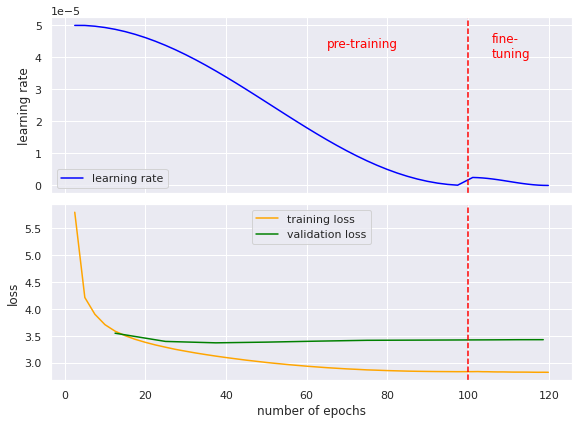

In [6]:
border = pre_train_hist["num_samples"].max() / 410000

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

ax1.text(border / 2 + 15, 4.3e-5, "pre-training", color="red", fontsize=12)
ax1.text(border + 6, 4e-5, "fine-\ntuning", color="red", fontsize=12)
ax1.plot(
    lr["num_samples"] / 410000, lr["learning_rate"], label="learning rate", color="blue"
)
ax1.set_ylabel("learning rate")
ax1.legend()

ax2.set_ylabel("loss")
ax2.set_xlabel("number of epochs")
ax2.plot(
    loss["num_samples"] / 410000, loss["loss"], color="orange", label="training loss"
)
ax2.plot(
    val_loss["num_samples"] / 410000,
    val_loss["accuracy"],
    color="green",
    label="validation loss",
)
ax2.legend()

for ax in [ax1, ax2]:
    ax.axvline(border, linestyle="--", color="red")
fig.tight_layout()
output(fig, "pre-train-fine-tune")

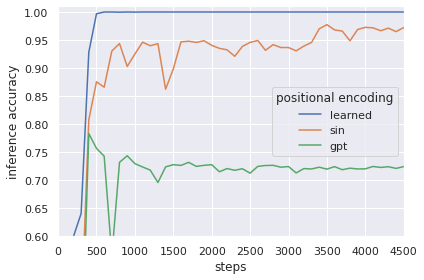

In [8]:
import json

names = ["learned-shared", "sin-shared", "gpt-shared"]

fig, ax = plt.subplots()
for name in names:
    with open(f"../captioning/overfit_results/accuracy-{name}.json", "r") as f:
        data = json.load(f)
    x = [x["step"] for x in data[1:]]
    y = [x["acc"] for x in data[1:]]

    if max(x) < 5000:
        x = x + list(range(max(x), 5000, 100))
        y = y + [y[-1]] * ((51 - len(y)))
    ax.plot(x, y, label=name.split("-")[0])


ax.legend(title="positional encoding")
ax.set_ybound(0.6, 1.01)
ax.set_xbound(0, 4500)
ax.set_xlabel("steps")
ax.set_ylabel("inference accuracy")
fig.tight_layout()
output(fig, "pos_enc")

In [9]:
# first sweep

runs = api.sweep("hpoeche-team/git-hp-search/ixqru2o7").runs
summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame(
    {"summary": summary_list, "config": config_list, "name": name_list}
)

In [10]:
runs_df["cider_d"] = runs_df["summary"].apply(lambda x: x.get("final_cider_mean") * 100)
runs_df["loss"] = runs_df["summary"].apply(lambda x: x.get("loss"))
runs_df["val_loss"] = runs_df["summary"].apply(lambda x: x.get("validation_loss"))

runs_df["augmentation"] = runs_df["config"].apply(
    lambda x: x.get("dataset").get("augmentation")
)
runs_df["cross_attention"] = runs_df["config"].apply(
    lambda x: x.get("model").get("cross_attention")
)
runs_df["pos_encoding"] = runs_df["config"].apply(
    lambda x: x.get("model").get("pos_encoding")
)
runs_df["batch_size"] = runs_df["config"].apply(
    lambda x: str(x.get("train").get("resulting_batch_size"))
)
runs_df["weight_decay"] = runs_df["config"].apply(
    lambda x: str(x.get("train").get("optimizer").get("args").get("weight_decay"))
)

runs_df.loc[runs_df["augmentation"].isnull(), "augmentation"] = "none"

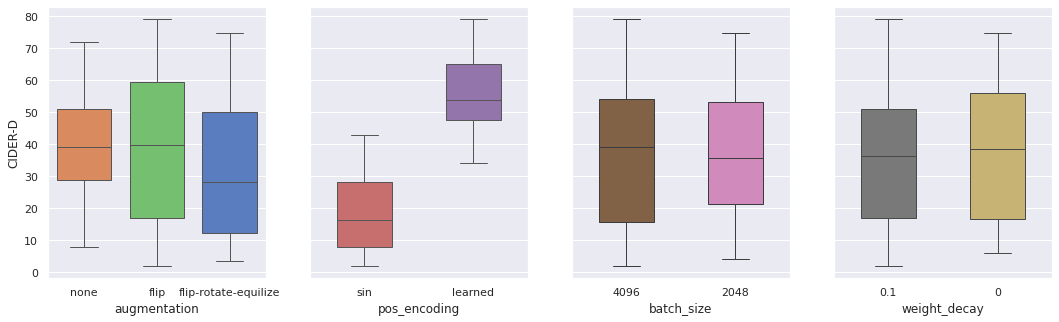

In [11]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(18, 5))

palette = cycle(sns.color_palette("muted"))
sns.boxplot(
    x="augmentation",
    y="cider_d",
    data=runs_df,
    hue="augmentation",
    palette=palette,
    ax=ax[0],
    width=0.75,
    order=["none", "flip", "flip-rotate-equilize"],
)
sns.boxplot(
    x="pos_encoding",
    y="cider_d",
    data=runs_df,
    hue="pos_encoding",
    palette=palette,
    ax=ax[1],
    width=0.5,
)
sns.boxplot(
    x="batch_size",
    y="cider_d",
    data=runs_df,
    hue="batch_size",
    palette=palette,
    ax=ax[2],
    width=0.5,
)
# sns.boxplot(
#     x="cross_attention",
#     y="cider_d",
#     data=runs_df,
#     hue="cross_attention",
#     palette=palette,
#     legend=None,
#     ax=ax[3],
#     width=0.5,
# )
sns.boxplot(
    x="weight_decay",
    y="cider_d",
    data=runs_df,
    hue="weight_decay",
    palette=palette,
    legend=None,
    ax=ax[3],
    width=0.5,
)

ax[0].set_ylabel("CIDER-D")
output(fig, "sweep_result")

In [12]:
import numpy as np
grouping = runs_df.groupby("pos_encoding")["cider_d"]
mean_diff = grouping.mean().diff().iloc[1]
s_y = runs_df["cider_d"].std()
n0n1 = grouping.count().prod()
nn = grouping.count().sum() * (grouping.count().sum() - 1)

# biserial correlation for pos_encoding vs. CIDEr-D
mean_diff / s_y * np.sqrt(n0n1 / nn)

-0.8362173341866311

In [13]:
runs_df.groupby("pos_encoding")["cider_d"].count().prod()

576

In [14]:
runs_df.groupby("pos_encoding")["cider_d"].median()

pos_encoding
learned    53.739929
sin        16.507912
Name: cider_d, dtype: float64

In [15]:
runs_df.groupby("augmentation")["cider_d"].describe()

,count,mean,std,min,25%,50%,75%,max
augmentation,,,,,,,,
flip,16.0,38.845653,25.091716,2.001825,16.854880,39.851877,59.335771,79.188781
flip-rotate-equilize,16.0,32.559940,24.171978,3.510671,12.344898,28.286784,50.023071,74.895401
none,16.0,39.596808,18.661130,7.981118,28.753625,39.266274,50.940277,72.090622


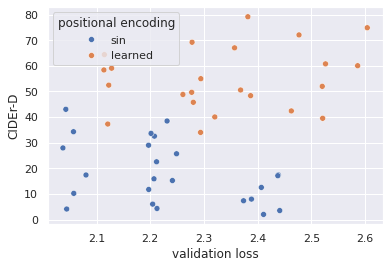

In [16]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=runs_df,
    x="val_loss",
    y="cider_d",
    hue="pos_encoding",
    ax=ax,
    s=35
)
ax.legend(title="positional encoding")
ax.set_xlabel("validation loss")
ax.set_ylabel("CIDEr-D")
output(fig, "sweep_no_corr")

In [17]:
runs_df[["cider_d", "val_loss"]].corr(method='pearson')

,cider_d,val_loss
cider_d,1.000000,0.240645
val_loss,0.240645,1.000000


In [18]:
runs_df[["cider_d", "val_loss", "pos_encoding"]].groupby("pos_encoding").corr(method='pearson')

cider_d  val_loss
pos_encoding                             
learned      cider_d   1.000000  0.193386
             val_loss  0.193386  1.000000
sin          cider_d   1.000000 -0.416466
             val_loss -0.416466  1.000000

In [19]:
runs = api.runs(
    "hpoeche-team/git-hp-search",
    filters={
        "$or": [{"sweep": "69jh3s8b"}, {"sweep": "4zwpdppw"}],
        "$and": [{"summary_metrics.cider_mean": {"$gt": 0.1}}],
    },
)

In [20]:
fields_of_interest = ["cider_mean", "loss", "validation_loss"]
first_sweep_df = load_histories(runs, fields_of_interest, x_axis="num_samples")
first_sweep_df["epochs"] = first_sweep_df["num_samples"] / 410000
first_sweep_df["cider_mean"] *= 100

100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


In [21]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [
        (h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]
    ]
    ax.legend(*zip(*unique))

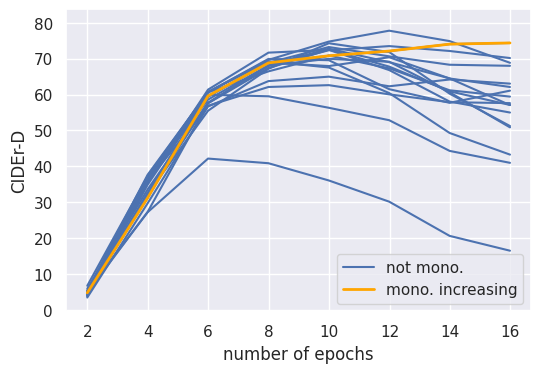

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

fig, ax = plt.subplots(dpi=100)

sns.lineplot(
    data=first_sweep_df.loc[
        ((first_sweep_df["epochs"] > 5) | (first_sweep_df["epochs"] < 4))
        & ((first_sweep_df["epochs"] <= 14) | (first_sweep_df["epochs"] > 15))
    ],
    x="epochs",
    y="cider_mean",
    units="run_id",
    estimator=None,
    label="not mono.",
    ax=ax,
)
sns.lineplot(
    data=first_sweep_df.loc[first_sweep_df["run_id"] == "9ti90ag5"],
    x="epochs",
    y="cider_mean",
    color="orange",
    label="mono. increasing",
    ax=ax,
    linewidth=2,
)

legend_without_duplicate_labels(ax)
ax.set_xlabel("number of epochs")
ax.set_ylabel("CIDEr-D")
output(fig, "non_monotonous")

In [24]:
runs = api.runs(
    "hpoeche-team/git-hp-search",
    filters={
        "$or": [
            {"sweep": "iipzekfl"},
            {"sweep": "ase4h58c"},
            {"sweep": "ffeaymwx"},
            {"sweep": "4zwpdppw"},
            {"sweep": "69jh3s8b"},
            {"sweep": "13g0h075"}
        ]
    },
)

rows = [
    {
        "run_id": run.id,
        "cider_mean": run.summary.get("cider_mean", 0) * 100,
        "d_ffn": run.config["model"]["d_ffn"],
        "num_layers": run.config["model"]["num_layers"],
        "dataset": (
            run.config["dataset"]["dataset"][0]
            if isinstance(run.config["dataset"]["dataset"], list)
            else run.config["dataset"]["dataset"]
        ),
        "augmentation": run.config["dataset"]["augmentation"],
    }
    for run in runs
]
all_runs_summary = pd.DataFrame(rows)
d_model = 768
calc_model_size = lambda ffn, layers: (
    (ffn * d_model * 2 + d_model**2 * 4 + ffn + 2 * d_model)
    * layers
) + d_model * 30_030
all_runs_summary["model_size"] = calc_model_size(all_runs_summary["d_ffn"], all_runs_summary["num_layers"])
all_runs_summary["llm_augment"] = all_runs_summary["dataset"] == "COCO-karpathy-llama"
all_runs_summary["dataset"] = "COCO-karpathy"
all_runs_summary["augmentation"] = all_runs_summary["augmentation"].fillna("none")
all_runs_summary.head()

,run_id,cider_mean,d_ffn,num_layers,dataset,augmentation,model_size,llm_augment
0,etwgsiq2,54.070192,1536,6,COCO-karpathy,none,51393024,False
1,k4hbzzss,40.968656,1536,6,COCO-karpathy,none,51393024,True
2,5zaqqqwi,59.360190,1536,6,COCO-karpathy,flip,51393024,False
3,2peo9ijq,18.423549,1536,6,COCO-karpathy,flip,51393024,True
4,ppgetyiv,48.138826,1536,6,COCO-karpathy,flip-rotate,51393024,False


In [25]:
## History
sweep_history = load_histories(runs, keys=fields_of_interest, x_axis="num_samples")
sweep_history["cider_mean"] *= 100
sweep_history["augmentation"] = sweep_history["run_id"].map(
    all_runs_summary.set_index("run_id")["augmentation"]
)
sweep_history["llm_augment"] = sweep_history["run_id"].map(
    all_runs_summary.set_index("run_id")["llm_augment"]
)
sweep_history["augmentation"] = sweep_history["augmentation"].fillna("none")
sweep_history.head()

  0%|          | 0/107 [00:00<?, ?it/s]

100%|██████████| 107/107 [00:15<00:00,  7.05it/s]


,cider_mean,loss,validation_loss,num_samples,run_id,augmentation,llm_augment
0,46.198150,3.584228,3.365950,2048000.0,etwgsiq2,none,False
1,57.509477,2.824845,2.740328,4096000.0,etwgsiq2,none,False
2,54.070192,2.535438,2.483547,6144000.0,etwgsiq2,none,False
3,NaN,7.648485,NaN,409600.0,etwgsiq2,none,False
4,NaN,5.475365,NaN,819200.0,etwgsiq2,none,False


In [26]:
sweep_history.loc[sweep_history["llm_augment"] == False, "epoch"] = (
    sweep_history.loc[sweep_history["llm_augment"] == False, "num_samples"] / 412672
)
sweep_history.loc[sweep_history["llm_augment"] == True, "epoch"] = (
    sweep_history.loc[sweep_history["llm_augment"] == True, "num_samples"] / 576596
)
sweep_history.loc[sweep_history["llm_augment"] == True, "augmentation"] = "llm"

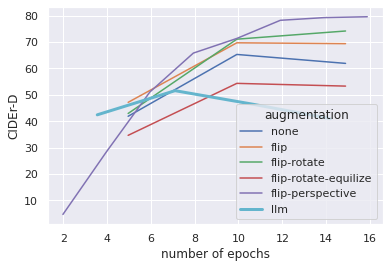

In [27]:
best_runs_per_aug = (
    sweep_history.set_index("epoch")
    .sort_index()
    .groupby("run_id")
    .last()
    .groupby("augmentation")
    .idxmax()["cider_mean"]
    .values
)
best_runs_per_aug_data = sweep_history.loc[
    sweep_history["run_id"].isin(best_runs_per_aug)
]

fig, ax = plt.subplots()

sns.lineplot(
    data=best_runs_per_aug_data.loc[best_runs_per_aug_data["augmentation"] != "llm"],
    x="epoch",
    y="cider_mean",
    hue="augmentation",
    hue_order=[
        "none",
        "flip",
        "flip-rotate",
        "flip-rotate-equilize",
        "flip-perspective",
    ],
    ax=ax,
)
sns.lineplot(
    data=best_runs_per_aug_data.loc[best_runs_per_aug_data["augmentation"] == "llm"],
    x="epoch",
    y="cider_mean",
    hue="augmentation",
    ax=ax,
    linewidth=3,
    palette=sns.color_palette()[9:],
)
ax.set_ylabel("CIDEr-D")
ax.set_xlabel("number of epochs")


output(fig, "best-run-for-augment")

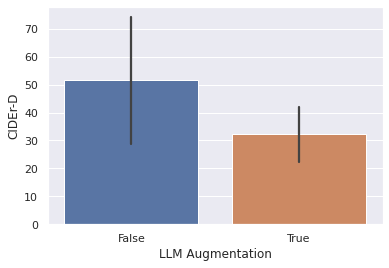

In [28]:
fig, ax = plt.subplots()
sns.barplot(
    data=all_runs_summary,
    x="llm_augment",
    y="cider_mean",
    hue="llm_augment",
    errorbar="sd",
    ax=ax,
    legend=False,
)
ax.set_ylabel("CIDEr-D")
ax.set_xlabel("LLM Augmentation")
output(fig, "llama-augment")

/tmp/ipykernel_952141/718284987.py:3: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(


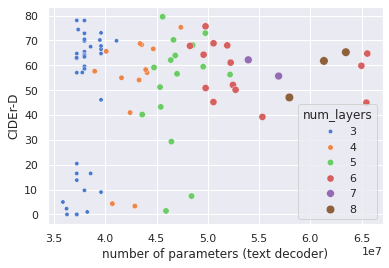

In [29]:
fig, ax = plt.subplots()
model_size_comp = all_runs_summary.loc[(all_runs_summary["llm_augment"] == False) & (all_runs_summary["augmentation"] == "flip-perspective")]
sns.scatterplot(
    data=model_size_comp,
    x="model_size",
    y="cider_mean",
    size="num_layers",
    hue="num_layers",
    #sizes=[50, 75, 100, 125],
    palette=sns.color_palette("muted"),
    ax=ax
)
sns.move_legend(ax, "lower right")
ax.set_ylabel("CIDEr-D")
ax.set_xlabel("number of parameters (text decoder)")
output(fig, "augment-model-size")

In [30]:
all_runs_summary[["cider_mean", "model_size"]].corr(method="pearson")

,cider_mean,model_size
cider_mean,1.000000,0.149523
model_size,0.149523,1.000000


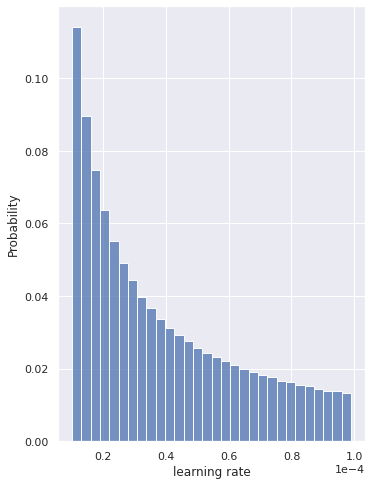

In [31]:
import numpy as np

def loguniform(low, high, size):
    return np.exp(np.random.uniform(np.log(low), np.log(high), size))

s_min = 1e-5
s_max = 10e-5
q = 0.000001

fig, ax = plt.subplots(figsize=(5.5, 8))
sns.histplot(data=np.arange(s_min, s_max, q)[np.digitize(loguniform(s_min, s_max, (1000000,)), np.arange(s_min, s_max, q)) - 1], ax=ax, bins=30, stat="probability")
ax.ticklabel_format(style="scientific", scilimits=[-4, 6])
ax.set_xlabel("learning rate")
output(fig, "log-search-space", transparent=True)

In [32]:
def digitize_series(series, digitsize):
    return series.apply(lambda x: round(x/digitsize)*digitsize)

100%|██████████| 6/6 [00:00<00:00, 46345.90it/s]
/tmp/ipykernel_952141/500715642.py:7: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(data=vit_ps_aug, x='model.patch_size', y='accuracy', hue="dataset.augmentation", hue_order=["None", "AutoAugment", "AutoAugment + CutMix"], palette=sns.color_palette("muted"), ax=ax)


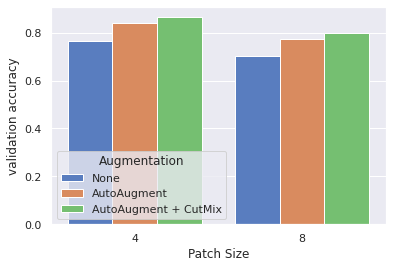

In [33]:
runs = api.runs("hpoeche-team/vit-classifier", filters={"tags": "ps-aug"})
vit_ps_aug = load_summaries(runs, ["accuracy"]).set_index("run_id").join(load_configs(runs, ["model.patch_size", "dataset.augmentation"]).set_index("run_id"))
vit_ps_aug["dataset.augmentation"] = vit_ps_aug["dataset.augmentation"].apply(lambda x: x.replace("AutoCIFAR10", "AutoAugment").replace("-", " + "))

fig, ax = plt.subplots()

sns.barplot(data=vit_ps_aug, x='model.patch_size', y='accuracy', hue="dataset.augmentation", hue_order=["None", "AutoAugment", "AutoAugment + CutMix"], palette=sns.color_palette("muted"), ax=ax)
ax.set_xlabel("Patch Size")
ax.set_ylabel("validation accuracy")
ax.legend(title="Augmentation", loc="lower left")

output(fig, "vit-patch-size")

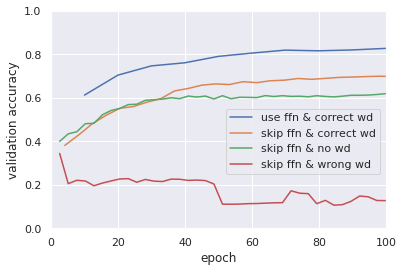

In [34]:
cifar_bugs_df = pd.read_csv('vit-cifar-bugs.csv')

cifar_size = 50000

armadillo = prepare_series(cifar_bugs_df, "chocolate-armadillo-72 - accuracy", 128, cifar_size)
dream = prepare_series(cifar_bugs_df, "lively-dream-103 - accuracy", 512, cifar_size)
fire = prepare_series(cifar_bugs_df, "expert-glitter-124 - accuracy", 128, cifar_size)
fire = fire[fire['epoch'] < 150]
peach = prepare_series(cifar_bugs_df, "peach-dew-71 - accuracy", 128, cifar_size)


x = 'epoch'
max = 100

fig, ax = plt.subplots()

ax.plot(fire[x], fire['value'], label="use ffn & correct wd")
ax.plot(dream[x], dream['value'], label="skip ffn & correct wd")
ax.plot(armadillo[x], armadillo['value'], label="skip ffn & no wd")
ax.plot(peach[x], peach['value'], label='skip ffn & wrong wd')
ax.legend(loc="center right", bbox_to_anchor=(1, 0.4))
ax.set_xlabel("epoch")
ax.set_ylabel("validation accuracy")
ax.set_ylim(0, 1)
ax.set_xlim(0, 100)

output(fig, "vit-bugs")

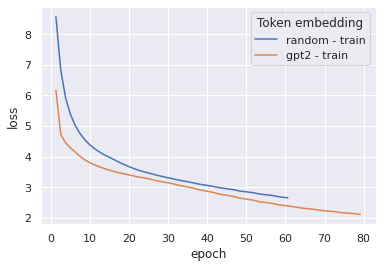

In [35]:
git = pd.read_csv('git-loss.csv')
git.head(2)

coco_size = 414000
resonance_train = prepare_series(git, "deep-resonance-10 - loss", 512, coco_size)
resonance_val = prepare_series(git, "deep-resonance-10 - accuracy", 512, coco_size)
resonance_val['value'] *= 1024

plasma_tain = prepare_series(git, "cool-plasma-16 - loss", 512, coco_size)
plasma_val = prepare_series(git, "cool-plasma-16 - accuracy", 512, coco_size)
plasma_val['value'] *= 1024

fig, ax = plt.subplots()

ax.plot(resonance_train['epoch'], resonance_train['value'], label="random - train")
ax.plot(plasma_tain['epoch'], plasma_tain['value'], label="gpt2 - train")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend(title="Token embedding")

output(fig, "git-gpt-embed")

In [36]:
final_runs = [api.run(get_run_id(name)) for name in ("colorful-sweep-6", "autumn-sweep-6", "fluent-sweep-3", "electric-aardvark-254")]
final_runs_df_raw = load_histories(final_runs, ["loss", "validation_loss", "cider_mean"], "num_samples")
final_runs_df_raw = final_runs_df_raw.set_index('run_id').join(load_configs(final_runs, ["dataset.dataset"]).set_index('run_id')).reset_index()

final_runs_df_raw.loc[final_runs_df_raw["dataset.dataset"].isin([['COCO-karpathy']]), "dataset.dataset"] = "COCO-karpathy"
fluent_samples = final_runs_df_raw.groupby('run_id')["num_samples"].max()['20nrl7gp']
final_runs_df_raw.loc[final_runs_df_raw["run_id"] == 'ugh989cb', "num_samples"] += fluent_samples

final_runs_df_raw.head()

100%|██████████| 4/4 [00:00<00:00, 31068.92it/s]


,run_id,loss,num_samples,validation_loss,cider_mean,dataset.dataset
0,ywdv606k,8.215412,409600.0,NaN,NaN,COCO-karpathy-llama
1,ywdv606k,6.202937,819200.0,NaN,NaN,COCO-karpathy-llama
2,ywdv606k,5.367741,1228800.0,NaN,NaN,COCO-karpathy-llama
3,ywdv606k,4.862631,1638400.0,NaN,NaN,COCO-karpathy-llama
4,ywdv606k,4.459746,2048000.0,NaN,NaN,COCO-karpathy-llama


In [37]:
augment_labels = pd.DataFrame(
    [
        ["COCO-karpathy", "none", 412672],
        ["COCO-karpathy-llama", "Llama 3B", 412672 * 1.4],
        ["COCO-karpathy-llama2", "Llama 8B", 412672 * 2],
    ],
    columns=["dataset", "text_augmentation", "ds_size"],
)

final_runs_df = final_runs_df_raw.join(augment_labels.set_index('dataset'), on='dataset.dataset').reset_index()
final_runs_df["epoch"] = final_runs_df["num_samples"] / final_runs_df["ds_size"]

losses = (
    final_runs_df.rename(columns={"loss": "training", "validation_loss": "validation"})[
        ["epoch", "training", "validation", "text_augmentation"]
    ]
    .melt(id_vars=["epoch", "text_augmentation"])
    .rename(columns={"variable": "split", "text_augmentation": "Text Augment"})
)
losses["metric"] = "loss"

ciders = final_runs_df.loc[~final_runs_df["cider_mean"].isnull(),["epoch", "text_augmentation", "cider_mean"]].rename(columns={"text_augmentation": "Text Augment", "cider_mean": "value"})
ciders["value"] *= 100
ciders["metric"] = "cider"
ciders["split"] = "validation"

long_data = pd.concat((losses, ciders))
long_data = long_data.loc[long_data["epoch"] < 100]
long_data.head()

,epoch,Text Augment,split,value,metric
0,0.708968,Llama 3B,training,8.215412,loss
1,1.417937,Llama 3B,training,6.202937,loss
2,2.126905,Llama 3B,training,5.367741,loss
3,2.835874,Llama 3B,training,4.862631,loss
4,3.544842,Llama 3B,training,4.459746,loss


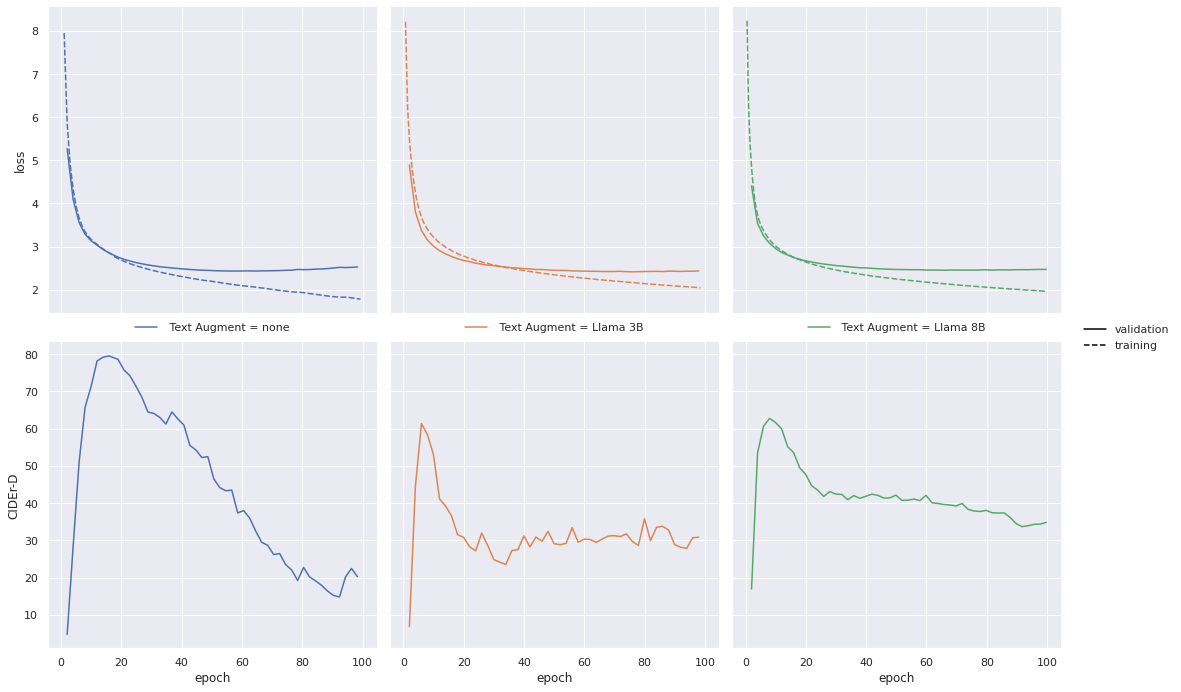

In [38]:
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
order = ["none", "Llama 3B", "Llama 8B"]

grid = sns.relplot(
    data=long_data,
    x="epoch",
    y="value",
    hue="Text Augment", hue_order=order,
    col="Text Augment", col_order=order,
    row="metric",
    style="split", style_order=["validation", "training"],
    kind="line", facet_kws=dict(sharey="row"),
    legend=False
)

grid.axes[0, 0].set_ylabel("loss")
grid.axes[1, 0].set_ylabel("CIDEr-D")

for ax in grid.axes[0]:
    ax.legend(
        [Line2D([0], [0], color=ax.lines[0].get_color())],
        [ax.get_title().split("|")[1]],
        frameon=False, loc="upper center", bbox_to_anchor=(.5, 0)
    )
    ax.set_title("")
    
for ax in grid.axes[1]:
    ax.set_title("")
    
grid.figure.legend(
    [Line2D([0], [0], color='black', linestyle='-'), Line2D([0], [0], color='black', linestyle='--')],
    ["validation", "training"],
    frameon=False, loc="center left", bbox_to_anchor=(1,.5)
)

output(grid.figure, "final_result", bbox_inches='tight')
    

In [39]:
long_data.loc[long_data.loc[(long_data["Text Augment"] == "Llama 8B") & (long_data["metric"] == "loss") & ~long_data["value"].isna()].groupby("split").idxmax()["epoch"]]

,epoch,Text Augment,split,value,metric
388,99.751861,Llama 8B,training,1.963380,loss
388,99.751861,Llama 8B,validation,34.812297,cider
943,99.751861,Llama 8B,validation,2.469659,loss
